In [1]:
import sys
sys.path.append("..")
from src.query_funcs import *
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("../datos/df_complete.csv", index_col=0)

In [3]:
df["Precio (€)"].max()

154.32

#### Conteo de productos por supermercado

In [4]:

conexion = conectar()
result = query_fetch(conexion, query_text='''select s.nombre AS nombre_supermercado,
	c.nombre as nombre_categoria,
    count(distinct p.nombre) as n_productos
from productos p
join supermercado s on p.id_supermercado = s.id_supermercado
join subcategorias sc on sc.id_subcat = p.id_subcat 
join categorias c on c.id_categoria = sc.id_categoria 
group by
    s.nombre, c.nombre
order by 
    n_productos DESC;''')

result_df = pd.DataFrame(result)
result_df.rename(columns=dict(enumerate(["Supermercado", "Categoria", "N de productos"])), inplace=True)
# result_df



In [5]:
px.bar(result_df, x = "Supermercado", y = "N de productos",
        color="Categoria", title ="Conteo de artículos por supermercado",
        color_discrete_sequence=px.colors.qualitative.Vivid)

#### Precios por supermercado (a día de hoy)

In [6]:
# df.groupby(["Categoria", "Supermercado"])[["Precio (€)","Nombre"]].agg(["describe", "nunique"])

# # df.groupby(["Categoria", "Supermercado"])

<Axes: xlabel='subcategoria', ylabel='precio'>

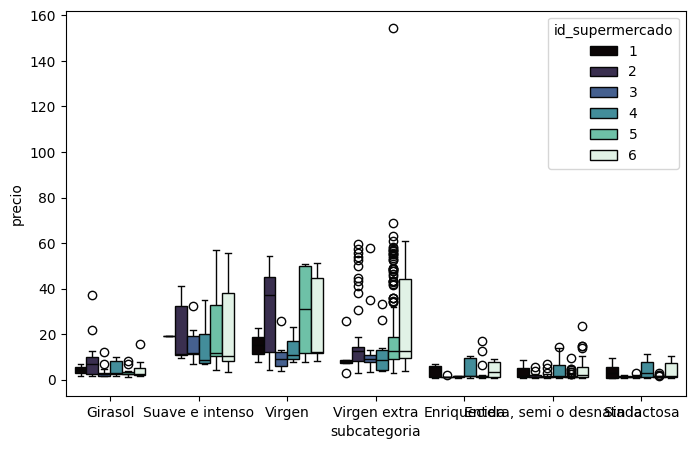

In [90]:
query = '''select r.id_producto, r.precio, 
		c.nombre as categoria,
		s.nombre as subcategoria,
		p.id_supermercado 	
from registros r
inner join productos p 
on p.id_producto = r.id_producto
inner join subcategorias s 
on p.id_subcat = s.id_subcat 
inner join categorias c 
on c.id_categoria = s.id_categoria 
where r.fecha = (select max(r2.fecha)
				 from registros r2 )
order by categoria, subcategoria;'''

conexion = conectar()
precios_ps = pd.DataFrame(query_fetch(conexion, query), columns=["id_producto", "precio", "categoria", "subcategoria", "id_supermercado"])

precios_ps
plt.figure(figsize = (8,5))
sns.boxplot(precios_ps, y = "precio", x = "subcategoria", hue = "id_supermercado", palette = "mako")

In [97]:
df[df["Precio (€)"] == df["Precio (€)"].max()]["Nombre"].unique()

array(['PICUALIA aceite de oliva virgen extra Picual pack 3 garrafas 5 l caja 15 l en Hipercor'],
      dtype=object)

#### Variación de precios por categoría, por meses

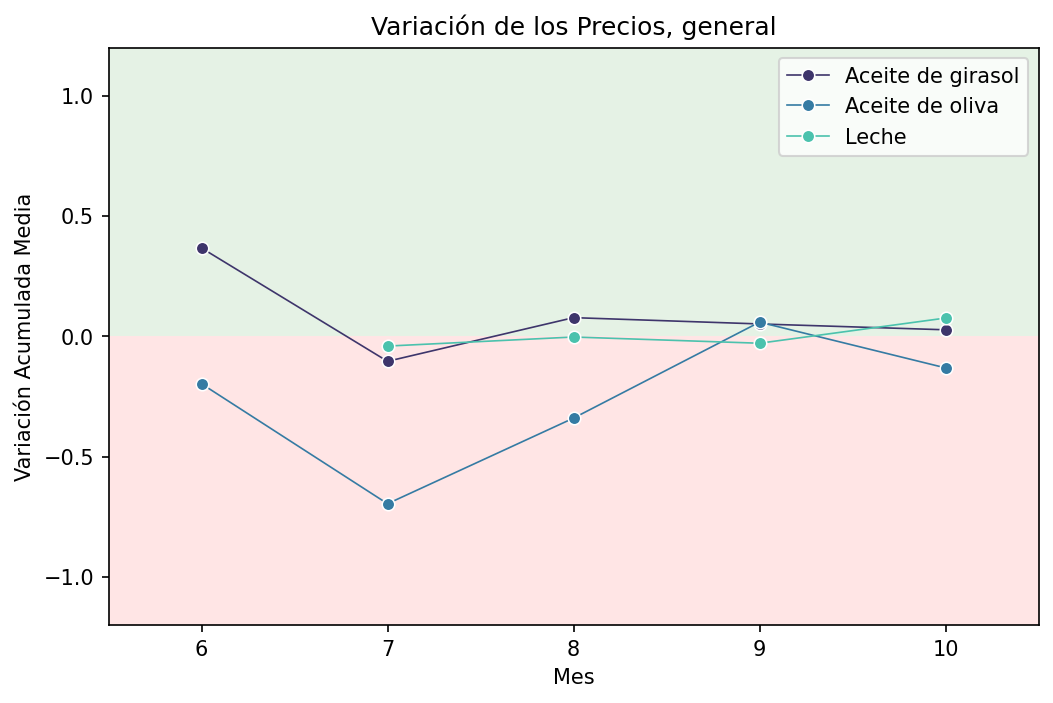

In [76]:
query = '''with variacion_acumulada as(
select extract (month from r.fecha) as mes,
				p.id_producto, s.id_categoria, 
				p.id_supermercado,
				sum(r.var_abs) as variacion_ac
from registros r 
inner join productos p on p.id_producto = r.id_producto 
inner join subcategorias s on s.id_subcat = p.id_subcat
group by mes, p.id_producto, s.id_categoria, p.id_supermercado
order by id_producto
)
select mes, c.nombre, avg(variacion_ac), id_supermercado
from variacion_acumulada va
inner join categorias c on c.id_categoria = va.id_categoria
group by c.nombre, mes, id_supermercado
order by id_supermercado,c.nombre, mes'''

conexion = conectar()
result = pd.DataFrame(query_fetch(conexion, query))
result.rename(columns=dict(enumerate(["mes", "categoria", "variacion_acum_media", "id_supermercado"])), inplace=True)
result["variacion_acum_media"] = result["variacion_acum_media"].apply(lambda x:round(x, ndigits=3))

plt.figure(figsize=(8,5), dpi = 150)
plt.title("Variación de los Precios, general")
sns.lineplot(result, x = "mes", y="variacion_acum_media", hue = "categoria", errorbar=None,
             marker = "o", palette = "mako", lw = 0.8,)
plt.xticks(np.arange(min(result["mes"]), max(result["mes"])+1, 1))
plt.ylabel('Variación Acumulada Media')
plt.xlabel('Mes')
plt.ylim(-1.2,1.2)
plt.xlim(5.5,10.5)
plt.axvspan(xmin = 5, xmax = 11,ymin = -1, ymax=0.5, facecolor = "red", alpha = 0.1)
plt.axvspan(xmin = 5, xmax = 11,ymin = 0.5, ymax=1, facecolor = "green", alpha = 0.1)
plt.legend()
plt.show()

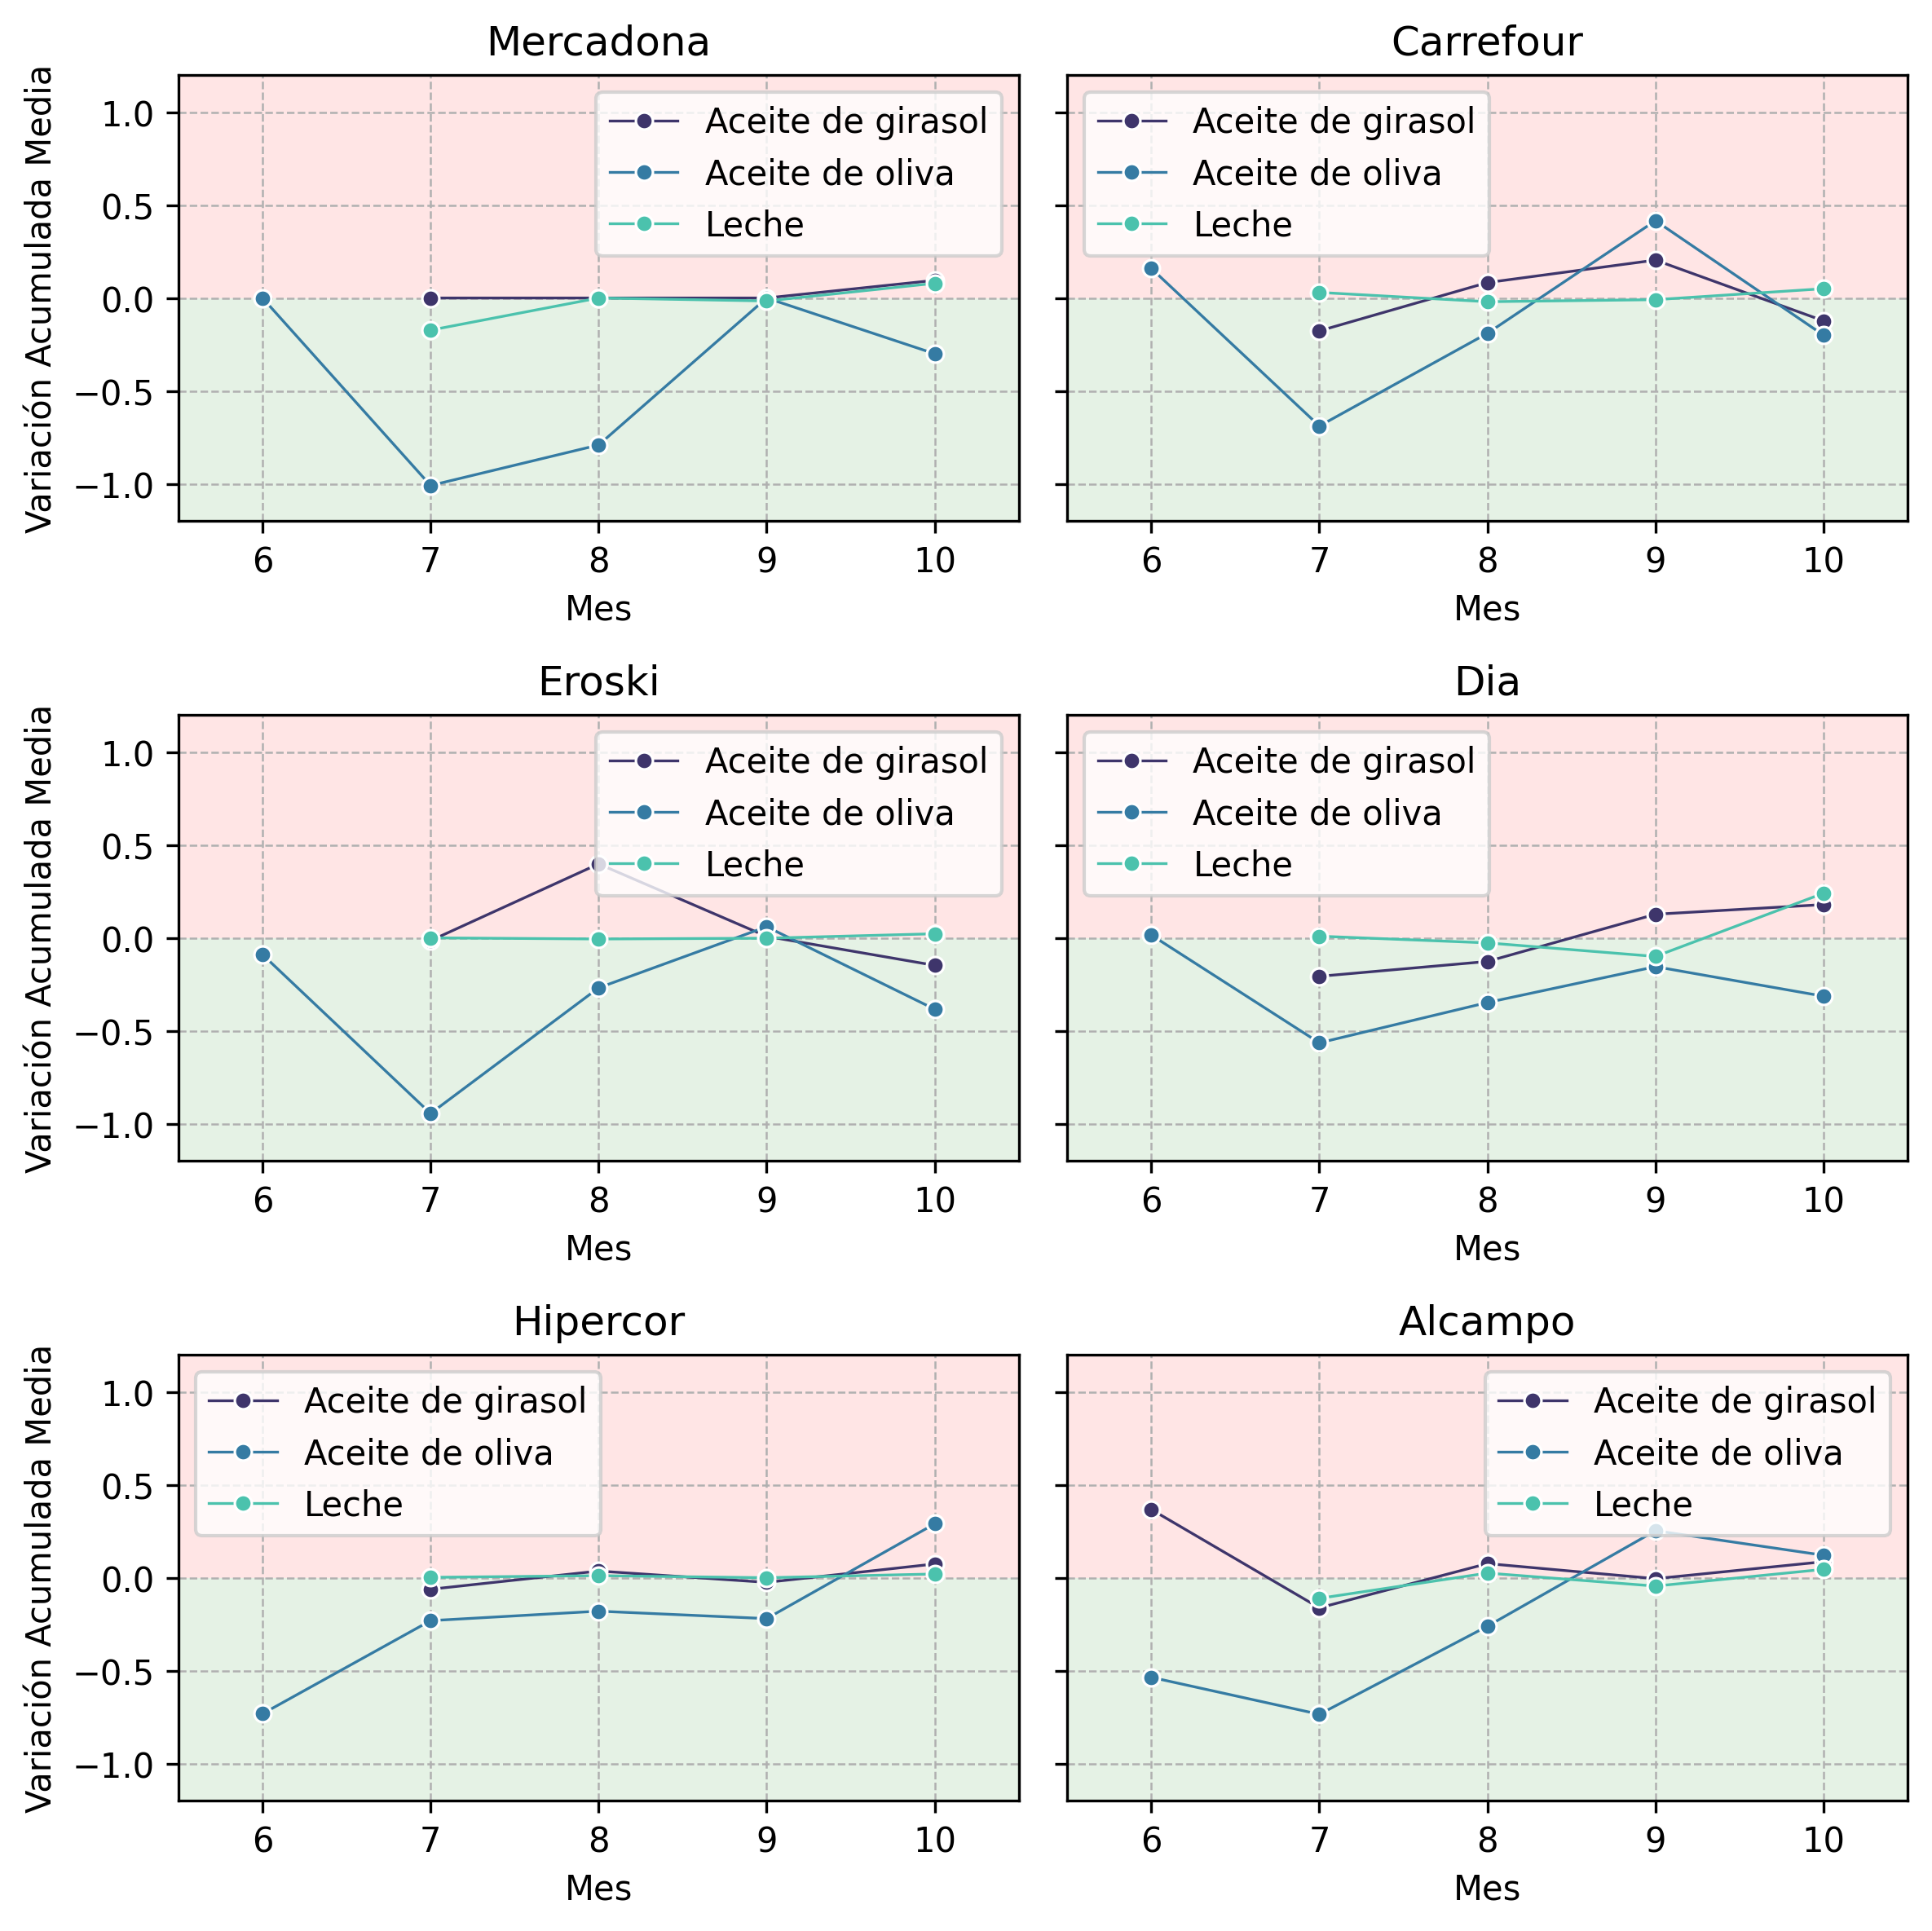

In [77]:
query = '''with variacion_acumulada as(
select extract (month from r.fecha) as mes,
				p.id_producto, s.id_categoria, 
				p.id_supermercado,
				sum(r.var_abs) as variacion_ac
from registros r 
inner join productos p on p.id_producto = r.id_producto 
inner join subcategorias s on s.id_subcat = p.id_subcat
group by mes, p.id_producto, s.id_categoria, p.id_supermercado
order by id_producto
)
select mes, c.nombre, avg(variacion_ac), s.nombre as supermercado
from variacion_acumulada va
inner join categorias c on c.id_categoria = va.id_categoria
inner join supermercado s on va.id_supermercado = s.id_supermercado
group by c.nombre, mes, s.id_supermercado 
order by s.id_supermercado ,c.nombre, mes'''

conexion = conectar()
result = pd.DataFrame(query_fetch(conexion, query))
result.rename(columns=dict(enumerate(["mes", "categoria", "variacion_acum_media", "id_supermercado"])), inplace=True)
result["variacion_acum_media"] = result["variacion_acum_media"].apply(lambda x: round(x, ndigits=3))

supermercados = result['id_supermercado'].unique()
n_cols = 2  
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8,8), sharey=True, dpi = 300)
axes = axes.flatten()

for i, supermercado in enumerate(supermercados):
    df_supermercado = result[result['id_supermercado'] == supermercado]
    axes[i].grid(lw = 0.6, ls = "--")
    sns.lineplot(data=df_supermercado, x="mes", y="variacion_acum_media", hue="categoria", errorbar=None,
                 marker="o", palette = "mako", lw = 0.8, markersize = 5, ax=axes[i])
    axes[i].axvspan(xmin = 5, xmax = 11,ymin = -1, ymax=0.5, facecolor = "green", alpha = 0.1)
    axes[i].axvspan(xmin = 5, xmax = 11,ymin = 0.5, ymax=1, facecolor = "red", alpha = 0.1)
    axes[i].set_title(f'{supermercado}'.capitalize())
    axes[i].set_ylim(-1.2,1.2)
    axes[i].set_xlim(5.5,10.5)
    axes[i].set_xlabel("Mes")
    axes[i].set_ylabel("Variación Acumulada Media")
    axes[i].legend()

plt.tight_layout()
plt.show()
